## Advanced Lane Finding Project

#### The goals / steps of this project are the following:

* Step 1: Compute the camera calibration matrix and distortion coefficients.
* Step 2: Apply a distortion correction to raw images.
* Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.
* Step 4: Apply a perspective transform to rectify binary image ("birds-eye view").
* Step 5: Detect lane pixels and fit to find the lane boundary.
* Step 6: Determine the curvature of the lane and vehicle position with respect to center.
* Step 7: Warp the detected lane boundaries back onto the original image.
* Step 8: Create visual display of lane boundaries and estimate lane curvature & vehicle position.

## Function Library

In [1]:
import numpy as np
import cv2
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from IPython.display import Markdown, display, HTML
from moviepy.editor import VideoFileClip
from moviepy.video.io.bindings import mplfig_to_npimage
%matplotlib inline

def printmd(string):
    display(Markdown(string))
    
def strip_after(string, char = '\\'):
    stripped = string[string.rfind(char)+1:]
    return stripped

def plot_image_row(names, x, row, cols):
    plt.figure(figsize=(10,8))
    index = row * cols
    fig = 1
    for col in range(cols):
        if index < min((row + 1) * cols, len(names)):
            plt.subplot(1, cols, fig)
            plt.title(strip_after(names[index]), fontsize=14)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(x[index], cmap='gray', interpolation='nearest')
            index += 1
            fig += 1
    plt.show()
        
def plot_images(names, x, cols = 5, n_samples = None):
    if n_samples == None:
        sample_x = x
        sample_names = names
    else:
        sample_x = []
        sample_names = []
        samples = random.sample(list(range(0, len(x))), n_samples)
        for i in samples:
            sample_x.append(x[i])
            sample_names.append(names[i])
    indices = range(len(sample_x))
    rows = np.ceil(len(indices) / cols).astype('uint32')
    index = 0
    for row in range(rows):
        plot_image_row(sample_names, sample_x, row, cols)

def calibrate(fNames):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    image_names = glob.glob(fNames)

    # Step through the list and search for chessboard corners
    images = []
    names = []
    bad_images = []
    bad_names = []
    for fname in image_names:
        img = cv2.imread(fname)
        #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        gray = img[:,:,0]

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

        # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            images.append(img)
            names.append(fname)
        else:
            bad_images.append(img)
            bad_names.append(fname)

    # Get Image Size
    img_size = (images[0].shape[1], images[0].shape[0])

    # Remove distortion
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                imgpoints, img_size, None, None)
    
    return mtx, dist, names, images, bad_names, bad_images

def sobel_thresh(img, orient='x', thresh=(0,255)): 
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=.8, tileGridSize=(4,4))
    gray = clahe.apply(np.uint8(gray))
    # 3) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y': sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 4) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 5) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 6) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & \
                  (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, m_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= m_thresh[0]) & (gradmag <= m_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def hls_thresh(img, channel='s', thresh=(0,255)):
# Convert to HLS color space
    if channel == 'h': n_channel = 0
    if channel == 'l': n_channel = 1
    if channel == 's': n_channel = 2
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_channel = hls[:,:,n_channel]
# Threshold color channel
    hls_binary = np.zeros_like(hls_channel)
    hls_binary[(hls_channel >= thresh[0]) & (hls_channel <= thresh[1])] = 1

    return hls_binary

def rgb_thresh(img, channel='r', thresh=(0,255)):
# Convert to RGB color space
    if channel == 'r': n_channel = 0
    if channel == 'g': n_channel = 1
    if channel == 'b': n_channel = 2
    # Threshold color channel
    rgb_binary = np.zeros_like(img[:,:,n_channel])
    rgb_binary[(img[:,:,n_channel] > thresh[0]) & (img[:,:,n_channel] <= thresh[1])] = 1

    return rgb_binary

def pipeline(img, sobel_kernel=3, m_thresh=(30,100), 
             s_thresh=(40, 100), r_thresh=(200, 255), sx_thresh=(20, 100)):  
    # Get HLS S channel
    s_binary = hls_thresh(img, 's', s_thresh)
    # Get RGB R channel
    r_binary = rgb_thresh(img, 'r', r_thresh)
    # Get Sobel x   
    sxbinary = sobel_thresh(img, 'x', sx_thresh)
    # Get Magnitude of the Gradient
    mag_binary = mag_thresh(img, sobel_kernel, m_thresh)
    # Get Directional Threshold    
    dir_binary = dir_threshold(img, sobel_kernel, thresh=(0.7, 1.3))

# Combine the binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((((dir_binary == 1) & (mag_binary == 1)) | (sxbinary == 1)) & \
                     ((s_binary == 1) | (r_binary == 1)))] = 1
    return combined_binary

# Get lane anchors
def get_anchor(img, anchor, side='r', offset=200):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    leftx_anchor = anchor + np.argmax(histogram[anchor:anchor + offset])
    rightx_anchor = anchor - offset + np.argmax(histogram[anchor - offset:anchor])
    if side == 'l': return leftx_anchor
    return rightx_anchor

# Fit polynomial to binary image with lines extracted
# (using sliding )
def extrap_lanes_init(img, left_anchor, right_anchor):
    global margin
    # Take a histogram of the bottom half of the image
    leftx_base = get_anchor(img, left_anchor, 'l')
    rightx_base = get_anchor(img, right_anchor, 'r')

    # Choose the number of sliding windows
    nwins = 10
    # Set height of windows
    win_h = np.int(img.shape[0]/nwins)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_center = leftx_base
    rightx_center = rightx_base
    # Set minimum number of pixels found to recenter window
    minpix = 20
    # Create empty lists to receive left and right lane pixel indices
    left_pix = []
    right_pix = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for win in range(nwins):
        # Identify window boundaries in x and y (and right and left)
        win_y_bot = img.shape[0] - (win + 1) * win_h
        win_y_top = img.shape[0] - win * win_h
        win_xleft_bot = leftx_center - margin
        win_xleft_top = leftx_center + margin
        win_xright_bot = rightx_center - margin
        win_xright_top = rightx_center + margin
        rectangle_data.append((win_xleft_bot, win_y_bot, win_xleft_top, win_y_top,
                               win_xright_bot, win_y_bot, win_xright_top, win_y_top))
        # Identify the nonzero pixels in x and y within the window
        inrange_left_pix = ((nonzeroy >= win_y_bot) & (nonzeroy < win_y_top) & 
                            (nonzerox >= win_xleft_bot) & (nonzerox < win_xleft_top)).nonzero()[0]
        inrange_right_pix = ((nonzeroy >= win_y_bot) & (nonzeroy < win_y_top) & 
                             (nonzerox >= win_xright_bot) & (nonzerox < win_xright_top)).nonzero()[0]
        # Append these indices to the lists
        left_pix.append(inrange_left_pix)
        right_pix.append(inrange_right_pix)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(inrange_left_pix) > minpix:
            leftx_center = np.int(np.mean(nonzerox[inrange_left_pix]))
        if len(inrange_right_pix) > minpix:        
            rightx_center = np.int(np.mean(nonzerox[inrange_right_pix]))

    # Concatenate the arrays of indices
    left_pix = np.concatenate(left_pix)
    right_pix = np.concatenate(right_pix)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_pix]
    lefty = nonzeroy[left_pix] 
    rightx = nonzerox[right_pix]
    righty = nonzeroy[right_pix] 

    left_new, right_new = ([], [])
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_new = np.polyfit(righty, rightx, 2)
    return left_new, right_new, left_pix, right_pix, rectangle_data

# Fit polynomial to binary image continuously
# (assuming the fit will not change significantly from one video frame to the next)
def extrap_lanes(imgbw, left_fit, right_fit):
    global margin
    nonzero = imgbw.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_pix = ((nonzerox > (left_fit[0]*(nonzerox**2) + 
                left_fit[1]*nonzerox + left_fit[2] - margin)) & 
                (nonzerox < (left_fit[0]*(nonzerox**2) + 
                left_fit[1]*nonzerox + left_fit[2] + margin))) 
    right_pix = ((nonzerox > (right_fit[0]*(nonzerox**2) + 
                right_fit[1]*nonzerox + right_fit[2] - margin)) & 
                (nonzerox < (right_fit[0]*(nonzerox**2) + 
                right_fit[1]*nonzerox + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_pix]
    lefty = nonzeroy[left_pix] 
    rightx = nonzerox[right_pix]
    righty = nonzeroy[right_pix]
    
    left_new, right_new = ([], [])
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_new = np.polyfit(righty, rightx, 2)
    return left_new, right_new, left_pix, right_pix

# Measure Curvature Radius in Meters
def measure_curvature(num_rows, x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points * ym_per_pix, x_values * xm_per_pix, 2)
    radius = ((1 + (2 * fit_cr[0] * y_eval * ym_per_pix + \
               fit_cr[1])**2)**1.5) / np.absolute(2 * fit_cr[0])
    return radius

# Draw Polygon that highlights the lane
def draw_lane_poly(img, imgbw, left_fit, right_fit, Minv, image='original'):
    if left_fit == []  or right_fit == []:
        return img
    # Create an image to draw the lines on
    o_img = np.copy(img)
    warp_zero = np.zeros_like(imgbw).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h, w = imgbw.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=30)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,127,255), thickness=30)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    if image == 'original':
        newwarp = cv2.warpPerspective(color_warp, Minv, (w, h))
    else:
        newwarp = color_warp
    # Combine the result with the original image
    result = cv2.addWeighted(o_img, 1, newwarp, 0.5, 0)
    return result

#Perform a verification on the lanes:
# Check 1: check whether left and right fit exists
# Check 2: Calculate the tangent between left and right in two points, and check
#          whether threshold is between minSlope and maxSlope 

def verify_lanes(left_fit, right_fit,  left_fitx, right_fitx, 
                 minSlope=0, maxSlope=.15, max_pct_diff=.5):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if left_fit != []  and right_fit != []:
        status = False
        d0 = 0
        d1 = 0
        return status, d0, d1
        # Previous fit routine returned empty list
    else:
        # Difference of slope
        L_0 = 2 * left_fit[0] * 320 + left_fit[1]
        R_0 = 2 * right_fit[0] * 320 + right_fit[1]
        d0 =  np.abs(L_0 - R_0)

        L_1 = 2 * left_fit[0] * 720 + left_fit[1]
        R_1 = 2 * right_fit[0] * 720 + right_fit[1]
        d1 =  np.abs(L_1 - R_1)
        if d0 >= minSlope and d0 <= maxSlope and d1 >= minSlope and d1 <= maxSlope:
        # Difference in lane width
            lw_0 = right_fitx[0] - left_fitx[0]
            lw_1 = right_fitx[-1] - left_fitx[-1]
            if lw_1 == 0:
                status = False
            else:
                lw_pct_diff = lw_0 / lw_1
                if lw_pct_diff > 1 + max_pct_diff or lw_pct_diff < 1 / (1 + max_pct_diff):
                    status = False
                else:
                    status = True
        else:
            status = False
       
        return status, d0, d1

def get_b_histogram(img, imgbw, axbh, axbha):
    h, w = img.shape[:2]
    axbh.set_ylim([h,0])
    axbh.set_xlim([0,w])
    axbha.set_ylim([0,300])
    axbha.set_xlim([0,w])
    histogram = np.sum(imgbw[int(imgbw.shape[0]//2):,:], axis=0)
    axbh.set_xticklabels([])
    axbh.set_yticklabels([])
    axbha.set_xticklabels([])
    axbha.set_yticklabels([])
    axbh.set_xticks([])
    axbh.set_yticks([])
    axbha.set_xticks([])
    axbha.set_yticks([])
    return histogram

def get_continuous_curve(imgbw, left_fit, right_fit, ax2):
    global margin
    left_fit2, right_fit2, left_pix2, right_pix2 = \
        extrap_lanes(imgbw, left_fit, right_fit)
    #print(np.sum(left_pix2), np.sum(right_pix2))
    # Generate x and y values for plotting
    ploty = np.linspace(0, imgbw.shape[0] - 1, imgbw.shape[0] )
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    bwimg = np.uint8(np.dstack((imgbw, imgbw, imgbw)) * 255)
    laneimg = np.zeros_like(bwimg)
    # Color in left and right line pixels
    nonzero = imgbw.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    bwimg[nonzeroy[left_pix2], nonzerox[left_pix2]] = [255, 255, 0]
    bwimg[nonzeroy[right_pix2], nonzerox[right_pix2]] = [255, 255, 0]
    # Generate left and right polygons to illustrate the search area based on the previous fit
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_poly_left_side = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_poly_right_side = np.array([np.flipud(np.transpose(np.vstack([left_fitx +
                            margin, ploty])))])
    left_line_pts = np.hstack((left_poly_left_side, left_poly_right_side))
    right_poly_left_side = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_poly_right_side = np.array([np.flipud(np.transpose(np.vstack([right_fitx + 
                            margin, ploty])))])
    right_line_pts = np.hstack((right_poly_left_side, right_poly_right_side))
    cv2.fillPoly(laneimg, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(laneimg, np.int_([right_line_pts]), (0,255, 0))

    # Draw the lane onto the warped blank image
    result = cv2.addWeighted(bwimg, 1, laneimg, .5, 0)
    return result, left_fitx, right_fitx, ploty

def get_curvature(imgbw, left_fitx, right_fitx, img_size):
    # Calculate radii
    h = imgbw.shape[0]
    left_lane_radius = measure_curvature(h, left_fitx)
    right_lane_radius = measure_curvature(h, right_fitx)
    average_radius = (left_lane_radius + right_lane_radius)/2
    # compute the offset from the center
    lane_center = (right_fitx[-1] + left_fitx[-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix * center_offset_pixels
    return average_radius, left_lane_radius, right_lane_radius, center_offset_mtrs

#Function to process the image
counter = 0
ref_left  = np.array([-0.0001,0,400])
ref_right = np.array([-0.0001,0,1000])   
left_fit  = np.array([-0.0001,0,400])
right_fit = np.array([-0.0001,0,1000]) 

def process_image(img):
    global counter
    global ref_left 
    global ref_right
    global left_fit
    global right_fit
    
    margin = 40
    img = cv2.undistort(img, mtx, dist, None, mtx)
    imgtb = pipeline(img, sobel_kernel=9)
    imgbw = cv2.warpPerspective(imgtb, M_persp, img_size, flags=cv2.INTER_LINEAR)
    imgbv = cv2.warpPerspective(img, M_persp, img_size, flags=cv2.INTER_LINEAR)
    
    #Detect lanes and return fit curves
    if counter==0:
        left_fit, right_fit, _, _, _ = \
            extrap_lanes_init(imgbw, left_anchor, right_anchor)
    else:
        left_fit, right_fit, _, _ = extrap_lanes(imgbw, left_fit, right_fit)
    
    left_lane_radius = 0
    right_lane_radius = 0
    h = imgbw.shape[0]
    good_laneline = False
    
    if left_fit != []  and right_fit != []:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # compute curvature radii
        left_lane_radius = measure_curvature(h, left_fitx)
        right_lane_radius = measure_curvature(h, right_fitx)
    
    # Determine whether lane lines are good
        if counter == 0:
            good_laneline = True
        elif (left_lane_radius < 1000 or right_lane_radius < 1000):
            good_laneline = False
        else: 
            good_laneline, _, _ = verify_lanes(left_fit, right_fit, left_fitx, right_fitx)
    
    #Calc curvature and center
    smooth = .1
    if good_laneline: #Save as last reliable fit
        if counter == 0:
            ref_left, ref_right = left_fit, right_fit
        else:
            ref_left, ref_right = (left_fit * smooth) + (ref_left * (1 - smooth)), \
                                  (right_fit * smooth) + (ref_right * (1 - smooth))       
        counter += 1
    else: #Use the last realible fit
        left_fit, right_fit = ref_left, ref_right
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    # Warp back to original and merge with image
    imgop = draw_lane_poly(img, imgbw, ref_left, ref_right, Minv_persp)
    imgbp = draw_lane_poly(imgbv, imgbw, ref_left, ref_right, Minv_persp, 'bird')
    imgcv = np.zeros((720, 1280, 3), dtype=np.uint8)
    
    img_out = display_dashboard(img, imgcv, imgtb, imgbw, imgbp, imgop, left_fitx, 
                                right_fitx, img_size, good_laneline)

    return img_out

def display_dashboard(img, imgcv, imgtb, imgbw, imgbp, imgop, left_fitx, right_fitx,
                      img_size, good_laneline):
    global p_type
    fig = plt.figure(figsize=(15, 11), dpi=80)
    fig.tight_layout()
    gs = gridspec.GridSpec(5, 5)
    gs.update(hspace=0, wspace=0)
    ax1 = fig.add_subplot(gs[0, 0], xticks=[], yticks=[])
    # Create curvature image
    average_radius, left_lane_radius, right_lane_radius, center_offset_mtrs = \
            get_curvature(imgbw, left_fitx, right_fitx, img_size)
    TextA = "Average: " + str(int(average_radius)) + " m"
    TextL = "Left:        " + str(int(left_lane_radius)) + " m"
    TextR = "Right:      " + str(int(right_lane_radius))+ " m"
    TextC = "Ctr Offset:  " + str(round( center_offset_mtrs, 2)) + "m"
    TextG = "Good Lane Line: " + str(good_laneline)
    ax1.text(50, 100, TextA, fontsize=12, fontweight='bold', color='magenta')
    ax1.text(50, 200, TextL, fontsize=12, fontweight='bold', color='#1E90FF')
    ax1.text(50, 300, TextR, fontsize=12, fontweight='bold', color='red')
    ax1.text(50, 500, TextC, fontsize=12, fontweight='bold', color='lime')
    ax1.text(50, 600, TextG, fontsize=12, fontweight='bold', color='white')
    ax1.text(50, 700, 'Curvature', fontsize=12, fontweight='bold', color='white')
    ax1.imshow(imgcv, aspect='auto')
    ax2 = fig.add_subplot(gs[0, 1], xticks=[], yticks=[])
    ax2.text(50, 700, 'Binary Threshold', fontsize=12, fontweight='bold', color='white')
    ax2.imshow(imgtb, aspect='auto', cmap='gray')
    ax3 = fig.add_subplot(gs[0, 2], xticks=[], yticks=[])
    ax3a = ax3.twinx()
    histogram = get_b_histogram(img, imgbw, ax3, ax3a)
    ax3a.plot(histogram, 'c', linewidth=3)
    ax3.imshow(imgbw, aspect='auto', cmap='gray')
    ax3a.text(50, 8, "Bird's Eye Histogram", fontsize=12, fontweight='bold', color='white')
    ax4 = fig.add_subplot(gs[0, 3], xticks=[], yticks=[])
    ax4.text(50, 700, "Bird's Eye Lane Lines", fontsize=12, fontweight='bold', color='white')
    result, left_fitx, right_fitx, ploty = get_continuous_curve(imgbw, left_fit, right_fit, ax4)
    ax4.plot(left_fitx, ploty, color='red', linewidth=3)
    ax4.plot(right_fitx, ploty, color=[0,.5,1], linewidth=3)
    ax4.imshow(result, aspect='auto', cmap='gray')
    ax5 = fig.add_subplot(gs[0, 4], xticks=[], yticks=[])
    ax5.text(50, 700, "Bird's Eye View", fontsize=12, fontweight='bold', color='white')
    ax5.imshow(imgbp, aspect='auto')
    ax6 = fig.add_subplot(gs[1:, :5], xticks=[], yticks=[]);
    ax6.imshow(imgop, aspect='auto')
    for ax, color in zip([ax1, ax2, ax3, ax4, ax5, ax6], ['white'] * 6):
        plt.setp(ax.spines.values(), color=color, linewidth=3)

    img_out = mplfig_to_npimage(fig)
    if p_type == 'video': plt.close(fig)
    return img_out

print("All functions loaded")

All functions loaded


# Step 1 & 2: Correct Image Distortions

# Calibrations

## Random Chessboards with Corners Found

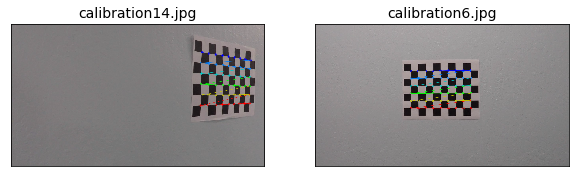

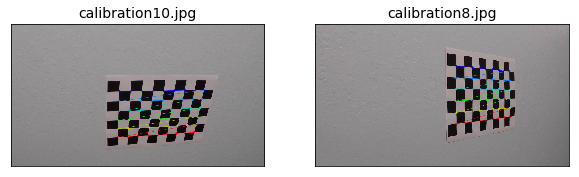

## Overly Cropped Chessboards (not used in calibration)

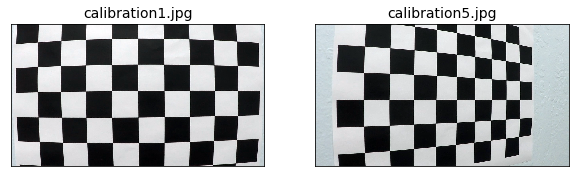

## Random Chessboards Before and After Calibration

### calibration16.jpg

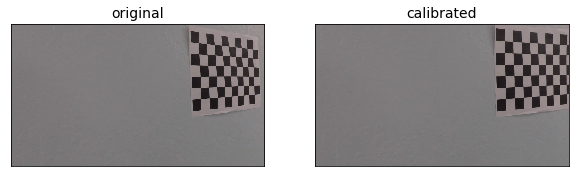

### calibration3.jpg

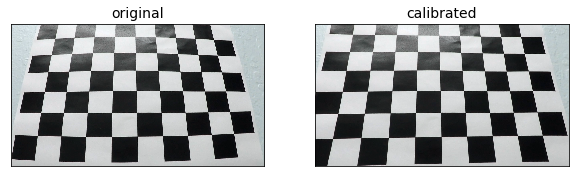

### calibration2.jpg

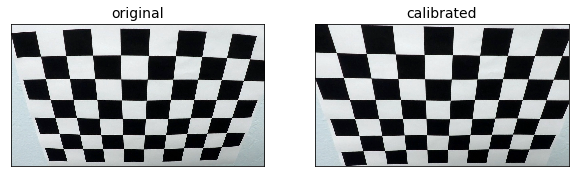

## Random Test Images Before and After Calibration

### test6.jpg

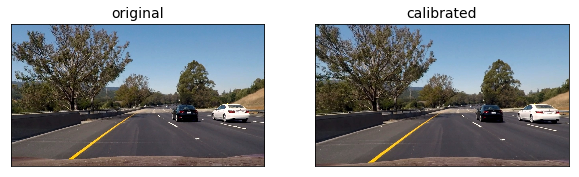

### test1.jpg

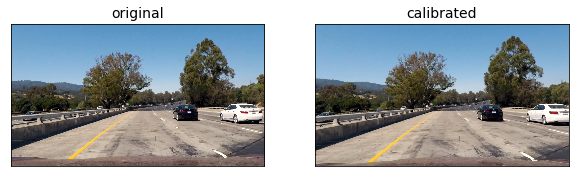

### test4.jpg

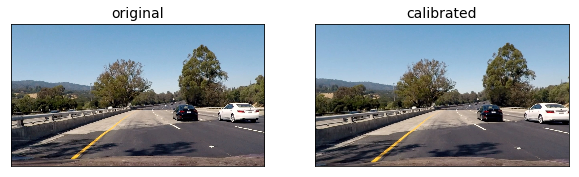

In [2]:
# Calibrate images
mtx, dist, names, images, bad_names, bad_images = calibrate('camera_cal/calibration*.jpg')

# Display Calibrations        
printmd("# Calibrations")
printmd("## Random Chessboards with Corners Found")
plot_images(names, images, 2, 6)
printmd("## Overly Cropped Chessboards (not used in calibration)")
plot_images(bad_names, bad_images, 2)


# Display Distorted and Calibrated Chessboards
printmd("## Random Chessboards Before and After Calibration")
samples = random.sample(list(range(0, len(images))), 3)
for i in samples:
    printmd("### " + strip_after(names[i]))
    img = cv2.imread(names[i])
    imgu = cv2.undistort(img, mtx, dist, None, mtx)
    plot_images(('original', 'calibrated'), (img, imgu), 2)

# Make a list of test images
image_names = glob.glob('test_images/*.jpg')

# Display Distorted and Calibrated Test Images
printmd("## Random Test Images Before and After Calibration")
t_images = []
t_names = []
samples = random.sample(list(range(0, len(image_names))), 3)
for i in samples:
    printmd("### " + strip_after(image_names[i]))
    img = cv2.imread(image_names[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgu = cv2.undistort(img, mtx, dist, None, mtx)
    plot_images(('original', 'calibrated'), (img, imgu), 2)

# Step 3: Create Thresholded Binary Images

## Random Test Images Before and After Binary Threshold

The thresholded binary image is a black and white copy of the original with
sobel x, hls s channel, magnitude and directional thresholds combined.


### test6.jpg

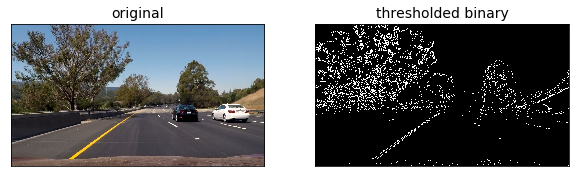

### test1.jpg

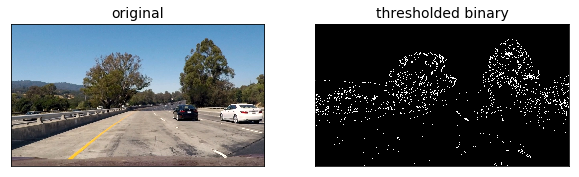

### test4.jpg

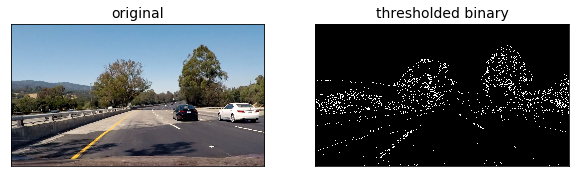

In [3]:
# Display Thresholded Binary Test Images
printmd("## Random Test Images Before and After Binary Threshold")
print("The thresholded binary image is a black and white copy of the " \
      "original with\nsobel x, hls s channel, magnitude and directional thresholds combined.")

#samples = random.sample(list(range(0, len(image_names))), 3)
for i in samples:
    printmd("### " + strip_after(image_names[i]))
    img = mpimg.imread(image_names[i])
    imgtb = pipeline(img, sobel_kernel=9)
    plot_images(('original', 'thresholded binary'), (img, imgtb), 2)

# Step 4: Perform Perspective Transform

## Create Lane Line Masks

### test6.jpg

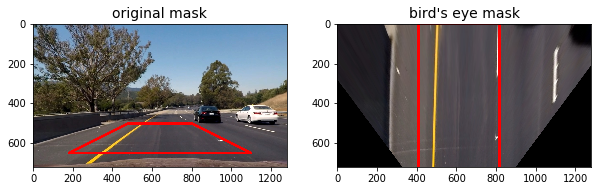

### test1.jpg

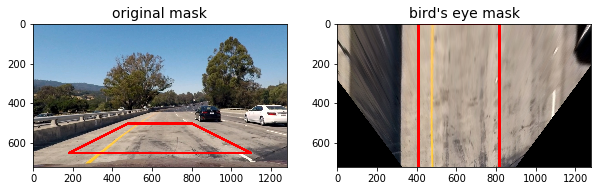

### test4.jpg

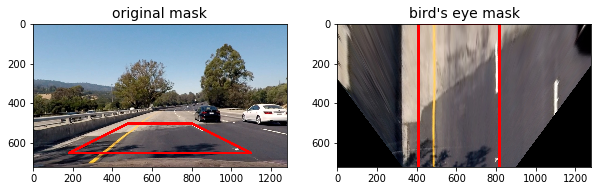

## Create Bird's Eye View from Thresholded Binary Images

### test6.jpg

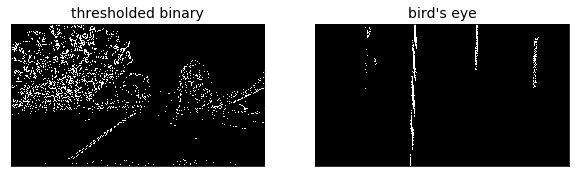

### test1.jpg

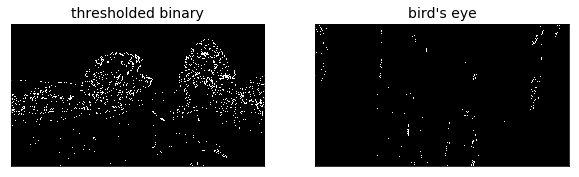

### test4.jpg

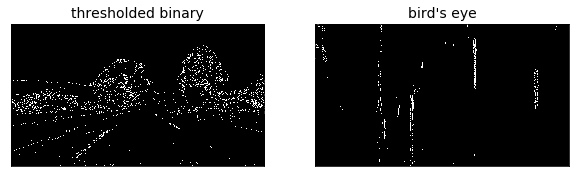

In [4]:
#Perspective transfomation

# Vertices extracted manually for performing a perspective transform
top = 500
bot = 650
bot_left = [180, bot]
bot_right = [1100, bot]
top_left = [480, top]
top_right = [800, top]

img = cv2.undistort(img, mtx, dist, None, mtx)
img_size = (img.shape[1], img.shape[0])
src = np.float32([bot_left, bot_right, top_right, top_left])

top = 0
bot = 720
left = 410
right = 820
dst = np.float32([[left, bot], [right, bot], [right, top], [left, top]])

M_persp = cv2.getPerspectiveTransform(src, dst)
Minv_persp = cv2.getPerspectiveTransform(dst, src)

printmd("## Create Lane Line Masks")
# Visualize Mask
#samples = random.sample(list(range(0, len(image_names))), 3)
for i in samples:
    printmd("### " + strip_after(image_names[i]))
    img = mpimg.imread(image_names[i])
    img = cv2.undistort(img, mtx, dist, None, mtx)
    imgbw = cv2.warpPerspective(img, M_persp, img_size, flags=cv2.INTER_LINEAR)
    h,w = img.shape[:2]
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    f.subplots_adjust(hspace = .2, wspace=.2)
    pts = np.array([bot_left, bot_right, top_right, top_left], np.int32)
    pts = pts.reshape((-1,1,2))
    img = cv2.polylines(img, [pts], True, (255, 0, 0), thickness=12)
    ax1.imshow(img)
    ax1.set_ylim([h,0])
    ax1.set_xlim([0,w])
    ax1.set_title('original mask', fontsize=14)
    pts = np.array([[left, bot + 10], [right, bot + 10], [right, top], [left, top]], np.int32)
    pts = pts.reshape((-1, 1, 2))
    imgbw = cv2.polylines(imgbw, [pts], True, (255, 0, 0), thickness=12)
    ax2.set_ylim([h, 0])
    ax2.set_xlim([0, w])
    ax2.set_title('bird\'s eye mask', fontsize=14)
    ax2.imshow(imgbw)
    plt.show()

printmd("## Create Bird's Eye View from Thresholded Binary Images")

for i in samples:
    printmd("### " + strip_after(image_names[i]))
    img = mpimg.imread(image_names[i])
    imgtb = pipeline(img, sobel_kernel=9)
    imgbw = cv2.warpPerspective(imgtb, M_persp, img_size, flags=cv2.INTER_LINEAR)
    plot_images(('thresholded binary', 'bird\'s eye'), (imgtb, imgbw), 2)

## Step 5: Identify Lane Line Pixels

## Create Bird's Eye View with Binary Activation Histogram

### test6.jpg

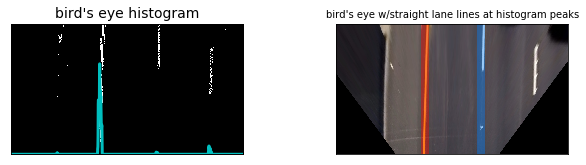

### test1.jpg

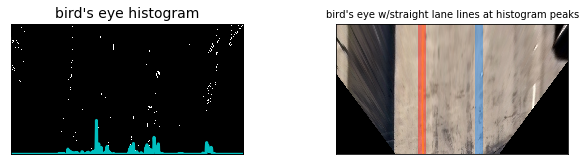

### test4.jpg

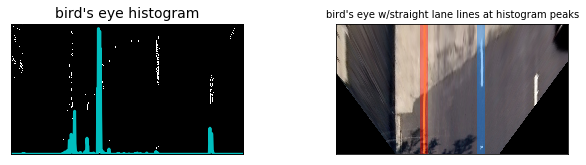

In [5]:
# Visualize Lane Line Pixels
printmd("## Create Bird's Eye View with Binary Activation Histogram")
#samples = random.sample(list(range(0, len(image_names))), 3)
for i in samples:
    printmd("### " + strip_after(image_names[i]))
    img = mpimg.imread(image_names[i])
    img = cv2.undistort(img, mtx, dist, None, mtx)
    imgtb = pipeline(img, sobel_kernel=9)
    imgbw = cv2.warpPerspective(imgtb, M_persp, img_size, flags=cv2.INTER_LINEAR)
    f, (axbh, ax2) = plt.subplots(1, 2, figsize=(10, 2.4))
    f.subplots_adjust(hspace = .2, wspace=.4)
    axbha = axbh.twinx()
    histogram = get_b_histogram(img, imgbw, axbh, axbha)
    axbha.plot(histogram, 'c', linewidth=3)
    axbh.set_title('bird\'s eye histogram', fontsize=14)
    axbh.imshow(imgbw, cmap='gray')

    imgow = cv2.warpPerspective(img, M_persp, img_size, flags=cv2.INTER_LINEAR)
    ax2.imshow(imgow)
    ax2.set_ylim([h,0])
    ax2.set_xlim([0,w])
    left_anchor = int(dst[0][0])
    left_line = get_anchor(imgbw, left_anchor, 'l')
    right_anchor = int(dst[2][0])
    right_line = get_anchor(imgbw, right_anchor, 'r')
    x = [left_line, left_line]
    y = [0, 720]
    ax2.plot(x, y, color='red', alpha=0.4, linewidth=8, solid_capstyle='round', zorder=2)
    x = [right_line, right_line]
    y = [0, 720]
    ax2.plot(x, y, color=[0,.5,1], alpha=0.4, linewidth=8, solid_capstyle='round', zorder=2)
    ax2.set_title('bird\'s eye w/straight lane lines at histogram peaks', fontsize=10)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.show()

## Step 6: Calculate Curve Radii

## Create Bird's Eye View with Curved Lines Highlighted

### test6.jpg

6425 2083


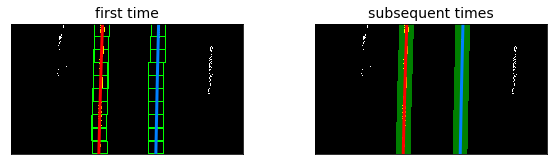

Average Curve Radius: 24576 m
Left Curve Radius:    18203 m
Right Curve Radius:   30949 m
Center offset:        0.02 m


### test1.jpg

644 909


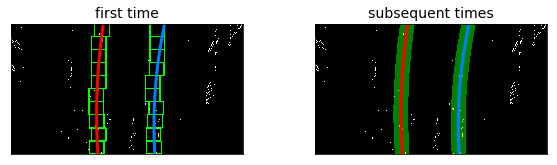

Average Curve Radius: 991 m
Left Curve Radius:    1103 m
Right Curve Radius:   878 m
Center offset:        0.01 m


### test4.jpg

3062 2497


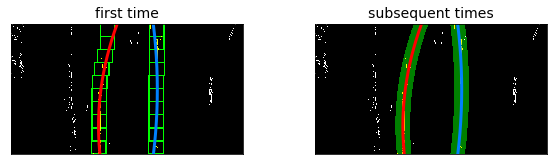

Average Curve Radius: 738 m
Left Curve Radius:    506 m
Right Curve Radius:   969 m
Center offset:        0.00 m


In [6]:
printmd("## Create Bird's Eye View with Curved Lines Highlighted")
margin = 40
for i in samples:
    printmd("### " + strip_after(image_names[i]))
    img = cv2.imread(image_names[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    imgtb = pipeline(img, sobel_kernel=9)
    imgbw = cv2.warpPerspective(imgtb, M_persp, img_size, flags=cv2.INTER_LINEAR)
    
    # Visualize Curved Lines First Time
    left_fit, right_fit, left_pix, right_pix, rectangles = \
        extrap_lanes_init(imgbw, left_anchor, right_anchor)
    print(len(left_pix), len(right_pix))
    # Create an output image to draw on and  visualize the result
    bw_img = np.uint8(np.dstack((imgbw, imgbw, imgbw))*255)
    # Generate x and y values for plotting
    ploty = np.linspace(0, imgbw.shape[0]-1, imgbw.shape[0])
    if left_fit != []  and right_fit != []:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        for rect in rectangles:
        # Draw the windows on the visualization image
            cv2.rectangle(bw_img,(rect[0:2]),(rect[2:4]),[0,255,0], 6) 
            cv2.rectangle(bw_img,(rect[4:6]),(rect[6:8]),(0,255,0), 6) 
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = imgbw.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bw_img[nonzeroy[left_pix], nonzerox[left_pix]] = [255, 255, 0]
        bw_img[nonzeroy[right_pix], nonzerox[right_pix]] = [255, 255, 0]
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.4))
        ax1.imshow(bw_img)
        ax1.plot(left_fitx, ploty, color='red', linewidth=3)
        ax1.plot(right_fitx, ploty, color=[0,.5,1], linewidth=3)
        ax1.set_title('first time', fontsize=14)
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_xticks([])
        ax1.set_yticks([])
    
    # Visualize Curved Lines Continuously
    if left_fit != []  and right_fit != []:
        result, left_fitx, right_fitx, ploty = get_continuous_curve(imgbw, left_fit, right_fit, ax2)
        ax2.plot(left_fitx, ploty, color='red', linewidth=3)
        ax2.plot(right_fitx, ploty, color=[0,.5,1], linewidth=3)
        ax2.imshow(result)
        ax2.set_title('subsequent times', fontsize=14)
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax2.set_xticks([])
        ax2.set_yticks([])
        plt.show()
        
        average_radius, left_lane_radius, right_lane_radius, center_offset_mtrs = \
            get_curvature(imgbw, left_fitx, right_fitx, img_size)
    # Display information
        print("Average Curve Radius: %.0f m" % average_radius)
        print("Left Curve Radius:    " + str(int(left_lane_radius)) + " m")
        print("Right Curve Radius:   " + str(int(right_lane_radius))+ " m")
        print("Center offset:        %.2f m" % center_offset_mtrs)

## Step 7: Warp Result onto Original Image

## Place Lane Polygon on Original Image

### test6.jpg

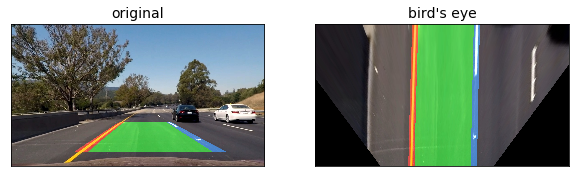

### test1.jpg

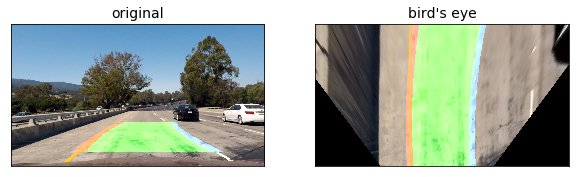

### test4.jpg

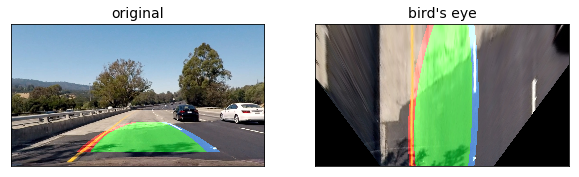

## Create Compound Display Images

### test6.jpg

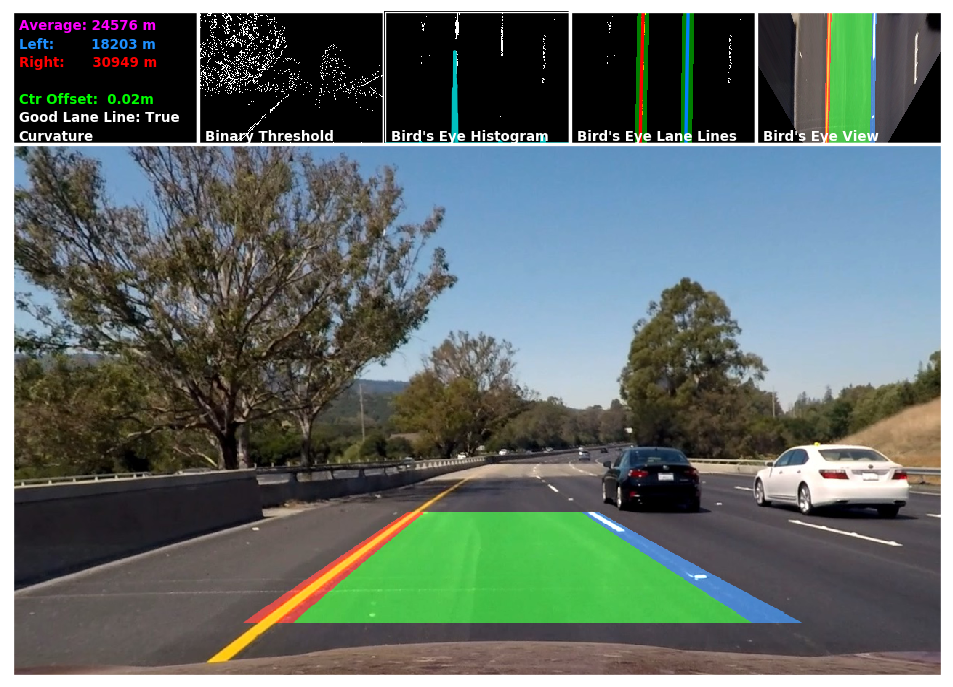

### test1.jpg

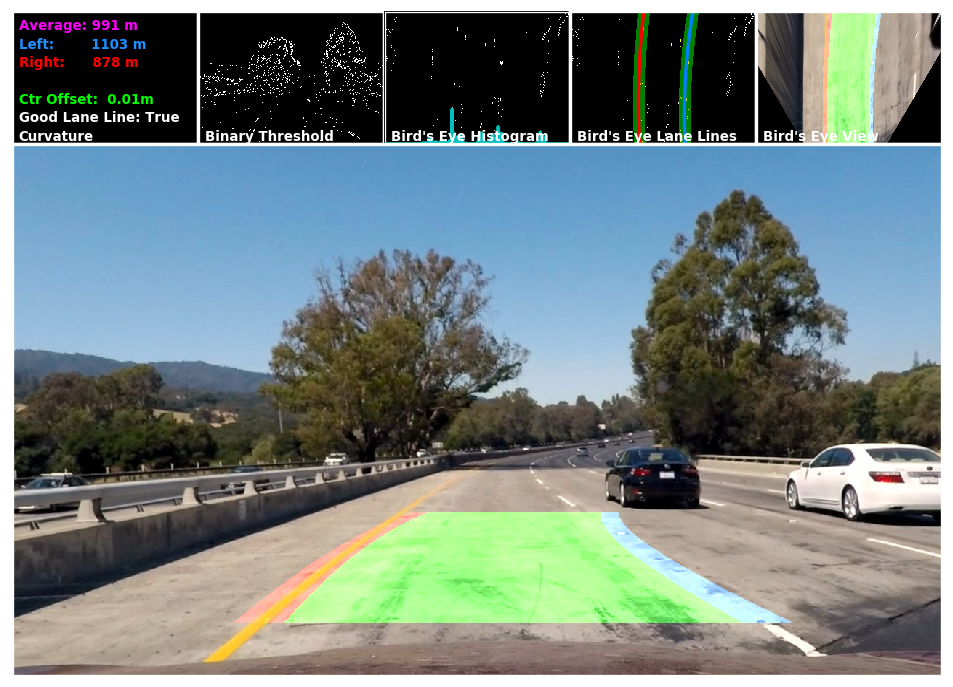

### test4.jpg

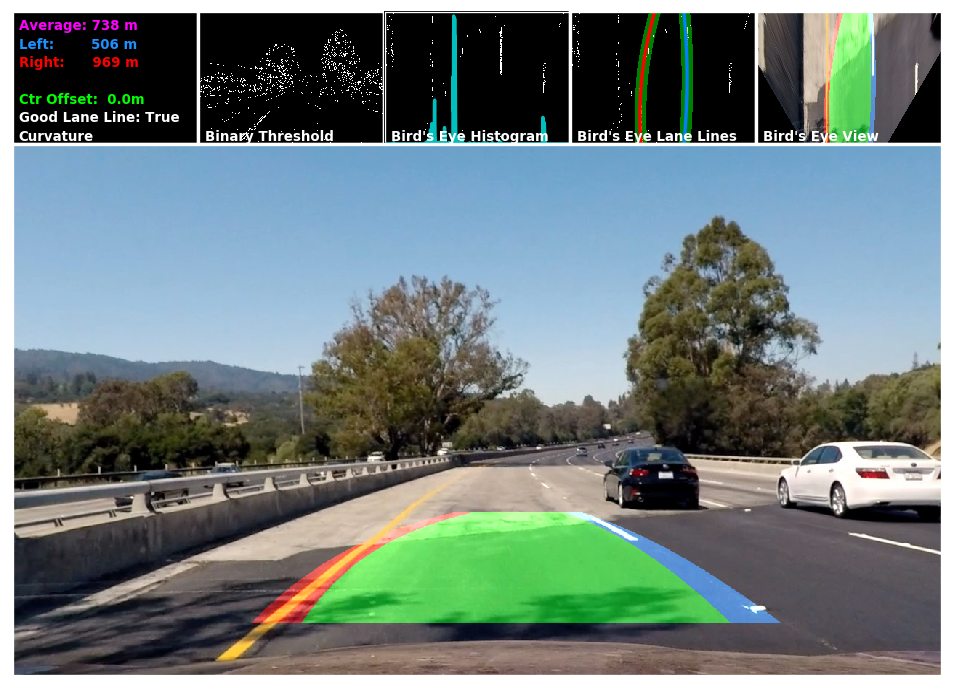

In [7]:
p_type = "images"
printmd("## Place Lane Polygon on Original Image")
for i in samples:
    printmd("### " + strip_after(image_names[i]))
    img = cv2.imread(image_names[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    imgtb = pipeline(img, sobel_kernel=9)
    imgbw = cv2.warpPerspective(imgtb, M_persp, img_size, flags=cv2.INTER_LINEAR)
    imgbv = cv2.warpPerspective(img, M_persp, img_size, flags=cv2.INTER_LINEAR)
    left_fit, right_fit, _, _, _ = \
        extrap_lanes_init(imgbw, left_anchor, right_anchor)
    img_op = draw_lane_poly(img, imgbw, left_fit, right_fit, Minv_persp)
    img_bp = draw_lane_poly(imgbv, imgbw, left_fit, right_fit, Minv_persp, 'bird')
    plot_images(('original', 'bird\'s eye'), (img_op, img_bp), 2)
    
printmd("## Create Compound Display Images")
for i in samples:
    printmd("### " + strip_after(image_names[i]))
    counter = 0
    img = cv2.imread(image_names[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = process_image(img)
    plt.show()

## Step 8: Create Video

In [8]:
p_type = "video"
video_list = ['project_video.mp4', 'challenge_video.mp4','harder_challenge_video.mp4']
#for i in range(len(video_list)):
for i in range(2):
    counter = 0
    video_name = video_list[i]
    printmd('## ' + video_name)
    video_output = 'test_videos_output/' + video_name
    vclip = VideoFileClip(video_name, target_resolution=(720, 1280))
    #vclip = VideoFileClip(video_name, target_resolution=(720, 1280)).subclip(20,21)
    out_clip = vclip.fl_image(process_image)
    out_clip.write_videofile(video_output, audio=False, verbose=False)
    out_clip.close
    out_clip.reader.close()
    out_clip.audio.reader.close_proc()

    display(HTML("""
    <video width="960" height="650" controls loop>
        <source src="{0}">
    </video>
    """.format(video_output)))

## project_video.mp4

100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:32<00:00,  2.71it/s]


## challenge_video.mp4

100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [03:11<00:00,  2.82it/s]
